In [1]:
#importing relevant libraries

from zaber_motion import Library
from zaber_motion.ascii import Connection
Library.enable_device_db_store()
from zaber_motion import Units
from controller import Imager
import cv2
import numpy as np
import time
import polanalyser as pa
from PIL import Image
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import os
import sys
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from scipy import ndimage
import glob

# %matplotlib notebook
import importlib
pyfilepath = '..//controller.py'
dirname, basename = os.path.split(pyfilepath) 
sys.path.append(dirname) 
module_name = 'controller'
controller = importlib.import_module(module_name) 

## Experiment parameters

exposure time = 3000 <br>
dsfbvdfb

In [2]:
#Functions code- from ASRI experiment (Vadim)


def float_round(x):
    """Round a float or np.float32 to a 3 digits float"""
    if type(x) == np.float32:
        x = x.item()
    return round(x,3) 

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def get_mean_responce_of_polarizer(img, polarizer_angle = 0):
    
    margine = 10
    _, roi,x_circ, y_circ, r_circ = get_IS_port_circle_roi(img, margine = margine)

    img_zero = np.zeros_like(img)
    
    if polarizer_angle == 0:
        img_zero[3::4, 3::4] = img[3::4, 3::4].copy()
    elif polarizer_angle == 90:
        img_zero[2::4, 2::4] = img[2::4, 2::4].copy()
    elif polarizer_angle == 45:
        img_zero[2::4, 3::4] = img[2::4, 3::4].copy()
    elif polarizer_angle == 135:
        img_zero[3::4, 2::4] = img[3::4, 2::4].copy()
    else:
        raise('Unknown option')
        
    print(x_circ, y_circ, r_circ)



    H,W = img_zero.shape
    circle_mask = create_circle(H,W,y_circ,x_circ, radius = r_circ - 1.5*margine)
    img_zero = circle_mask*img_zero

#     fig, ax = plt.subplots(nrows=1, ncols=1)
#     ax.imshow(img_zero)

    mean_at0_inside_mask = img_zero[img_zero > 0].mean()
    print('mean at polarizer 0 inside circle mask is {}'.format(mean_at0_inside_mask))
    return mean_at0_inside_mask

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def plot_hist_polarized(ax= None, data_for_hist=None, PIXELFORMAT = 'Mono12Packed', LOG = False):
    
    colors = ['green', 'blue', 'lime','red']
    labels = ['0','90','135','45']


    # the histogram of the data
    if PIXELFORMAT == 'Mono12Packed':
        
        if LOG:
            
            if PIXELFORMAT == 'Mono12Packed':
                M = 2**12    
            else:
                M = 2**8
            ax.hist( data_for_hist , 100 , [np.mean([data_for_hist.min()+1,0]),np.min([data_for_hist.max()+1,M])] , 
                    log=True,
                    histtype ='bar',
                    color = colors,
                    label = labels,edgecolor='k',rwidth=20)   

        else:
            
            ax.hist(data_for_hist, 100, density = True, 
                 histtype ='bar',
                 color = colors,
                 label = labels,edgecolor='k',rwidth=20)
            # nice reference - https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca
            ax.set_xlim([0,2**12])
            
    else:
        ax.hist(data_for_hist, 100, density = True, 
             histtype ='bar',
             color = colors,
             label = labels,edgecolor='k')

        ax.set_xlim([0,2**8])

    ax.legend(prop ={'size': 14})

    ax.set_title('Capture histogram\n',
              fontweight ="bold")

    ax.tick_params(labelsize=14)

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def create_circle(H,W,center_y,center_x,radius= 5):
    x = np.linspace(0,W,W, endpoint=False)
    y = np.linspace(0,H,H, endpoint=False)
    X, Y = np.meshgrid(x, y)
    A = (X - center_x)**2 + (Y - center_y)**2
    circle = A <= radius**2
    return circle

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def get_IS_port_circle_roi(original_image, margine = 10):
    """
    with the arguments:
    gray: Input image (grayscale).
    circles: A vector that stores sets of 3 values: xc,yc,r for each detected circle.
    HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV.
    dp = 1: The inverse ratio of resolution.
    min_dist = gray.rows/16: Minimum distance between detected centers.
    param_1 = 200: Upper threshold for the internal Canny edge detector.
    param_2 = 100*: Threshold for center detection.
    min_radius = 0: Minimum radius to be detected. If unknown, put zero as default.
    max_radius = 0: Maximum radius to be detected. If unknown, put zero as default.
    """
    VISUALIZE = False
    if original_image.dtype == 'uint16':
#         original_image = (2**8*(original_image/(2**12)))
        work_image = np.uint8((2**8*(original_image.copy()/(2**12))))
        
    img_gray = np.uint8(work_image).copy()
    img_gray = cv2.medianBlur(img_gray, 5)
    rows = img_gray.shape[0]
    
    circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
    
    if circle is None:
        img_gray = img_gray/np.max(img_gray)
        img_gray = np.uint8(255*img_gray)
        circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
        
        if circle is None:
#             img_gray = cv2.equalizeHist(img_gray)
#             circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
            if circle is None:
                circle = [[1236.5 ,1154.5 , 250.3]]

        
    print(circle)
    # convert the (x, y) coordinates and radius of the circles to integers
    circle = np.round(circle[0, :]).astype("int")
    # draw the circle in the output image, then draw a rectangle
    # corresponding to the center of the circle
    if VISUALIZE:
        cv2.namedWindow('Image', cv2.WINDOW_NORMAL)

    x, y, r = circle[0]
    # Center coordinates
    center_coordinates = (x,y)
    # Radius of circle
    radius = r
    radius_margine = r + margine
    # Blue color in BGR
    color = (0, 0, 255)
    # Line thickness of 2 px
    thickness = 10
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    # covert to RGB image just for circle visualization:
    img_rgb = np.dstack((img_gray,img_gray,img_gray))
    image = cv2.circle(img_rgb, center_coordinates, radius, color, thickness)
    roi = [int(x-radius_margine),int(y-radius_margine),int(x+radius_margine),int(y+radius_margine)]
#     img_gray = img_gray[int(y-radius_margine):int(y+radius_margine), int(x-radius_margine):int(x+radius_margine)]
    img_gray = original_image[int(y-radius_margine):int(y+radius_margine), int(x-radius_margine):int(x+radius_margine)]
    
    if VISUALIZE:
        cv2.imshow('Image',image)
        cv2.waitKey(0)
        cv2.destroyWindow('Image') 
    
    return img_gray, roi, x, y, r # use roi as: IMG[roi[1]:roi[3],roi[0]:roi[2]]


# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def clear_circle_edges(original_image, margine = 30):
    img_gray = original_image.copy()
    output = np.zeros_like(img_gray)
    croped_image, roi, x, y, r = get_IS_port_circle_roi(img_gray, margine = 30)
    radius_margine = r + margine
    x = x - int(x-radius_margine)
    y = y - int(y-radius_margine)
    
    H,W = croped_image.shape
    circle_mask = create_circle(H,W,y,x, radius = r - margine)

    output[roi[1]:roi[3],roi[0]:roi[2]] = circle_mask*croped_image
    
#     fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#     ax = ax.flatten()

#     im = ax[0].imshow(croped_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
#     divider = make_axes_locatable(ax[0])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     plt.colorbar(im, cax=cax)
#     ax[0].tick_params(labelsize=14)

#     im = ax[1].imshow(output, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
#     divider = make_axes_locatable(ax[1])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     plt.colorbar(im, cax=cax)
#     ax[1].tick_params(labelsize=14)
        
    return output

In [3]:
imager = Imager()
#num_cams = len(imager.cams)

Found 1 devices
Devices IDs - ['101936']


In [4]:
#sets up acquisition

imager._start_acquisitions()
imager.cams[-1].remote_device.node_map.ExposureAuto.value = 'Off'
PIXELFORMATS = {'8':'Mono8','12':'Mono12Packed'}
PIXELFORMAT = PIXELFORMATS['12']
imager.update_params(ExposureTime=1500, PixelFormat=PIXELFORMAT)#, AcquisitionFrameRate = 50)

In [7]:
#change the original exposure time to something else
#Set Exposure Time code- from ASRI Experiment (Vadim)

exposure=5000 

while(True):
    
    print('1')
#     imager._stop_acquisitions()
    imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)
#     imager._start_acquisitions()
    print('2')
    img, _ = imager.capture_sequence(1,0,0)
    time.sleep(0.1)
    img = np.squeeze(np.array(img))
    print('3')
    e = np.argwhere(img>=0.9*(2**12))
    print(exposure)
    print((len(e)/(img.shape[0]*img.shape[1])))
    if (len(e)/(img.shape[0]*img.shape[1])) < 0.001: # No saturation?
        break
    else:
        exposure = exposure - 1000

print("the found exposure time is {}".format(exposure))

1
2
0 - 2022-01-16 10:45:14.322411 - 101936 captured Mono12Packed image 
3
5000
0.014214808644812092
1
2
0 - 2022-01-16 10:45:15.146652 - 101936 captured Mono12Packed image 
3
4000
0.014059827218647876
1
2
0 - 2022-01-16 10:45:15.956150 - 101936 captured Mono12Packed image 
3
3000
0.013853185317095588
1
2
0 - 2022-01-16 10:45:16.780518 - 101936 captured Mono12Packed image 
3
2000
0.013445885352839053
1
2
0 - 2022-01-16 10:45:17.585384 - 101936 captured Mono12Packed image 
3
1000
0.012258492264093137
1


OutOfRangeException: Value 0.000000 must be greater than or equal 24.000000. : OutOfRangeException thrown in node 'ExposureTime' while calling 'ExposureTime.SetValue()' (file 'FloatT.h', line 89)

<IPython.core.display.Javascript object>


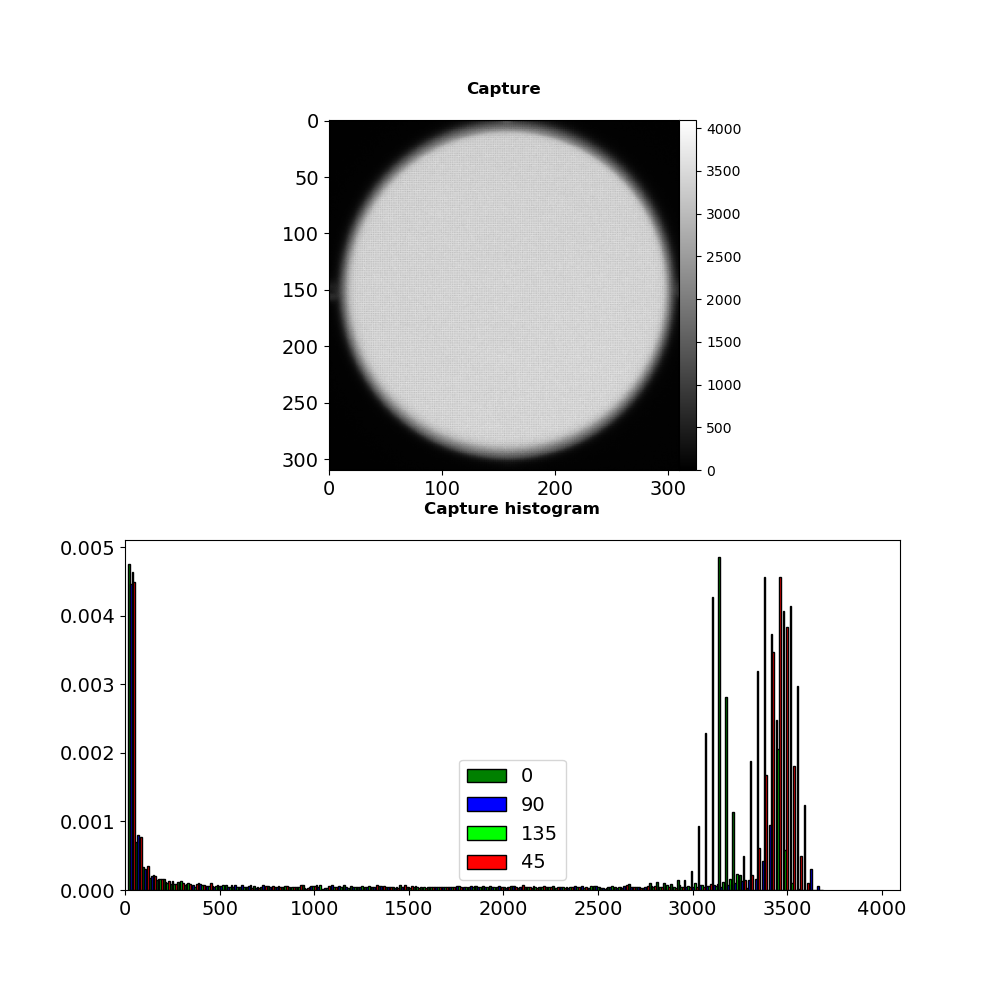

0 - 2022-01-16 12:23:29.089491 - 101936 captured Mono12Packed image 
[[[1096.5  957.5  145. ]]]


In [9]:
#Test the Histogram code- from ASRI Experiment (Vadim)

#manually set exposure time
exposure=1500 
imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)

#create histogram of image to test for saturation
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
ax = ax.flatten()

img, _ = imager.capture_sequence(1,0,0)
img = np.squeeze(np.array(img))

margine = 10
img, roi,x_circ, y_circ, r_circ = get_IS_port_circle_roi(img, margine = margine)

im_0   = img[3::4, 3::4]
im_90  = img[2::4, 2::4]
im_135 = img[3::4, 2::4]
im_45  = img[2::4, 3::4]



colors = ['green', 'blue', 'lime','red']
labels = ['0','90','135','45']

data_for_hist = np.vstack([im_0.ravel(),im_90.ravel(),im_135.ravel(),im_45.ravel()]).T

if PIXELFORMAT == 'Mono12Packed':
    im = ax[0].imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**12)

else:
    im = ax[0].imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**8)


divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax[0].tick_params(labelsize=14)
ax[0].set_title('Capture\n',
          fontweight ="bold")


# the histogram of the data
if PIXELFORMAT == 'Mono12Packed':
    ax[1].hist(data_for_hist, 100, density = True, 
         histtype ='bar',
         color = colors,
         label = labels,edgecolor='k',rwidth=20)
    # nice reference - https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca



    ax[1].set_xlim([0,2**12])
else:
    ax[1].hist(data_for_hist, 100, density = True, 
         histtype ='bar',
         color = colors,
         label = labels,edgecolor='k')

    ax[1].set_xlim([0,2**8])

ax[1].legend(prop ={'size': 14})

ax[1].set_title('Capture histogram\n',
          fontweight ="bold")

ax[1].tick_params(labelsize=14)


In [7]:
#for loop
#moves the gimbal and takes pictures, such that the light reaches all the pixels in the picture
#borders were chosen manually

  #borders according to the gimbal setup on 20/12/21:
  #borders named according to the gimbal, the light will be seen on the opposite "side"
  #left border: -19
  #right border: 19
  #top border: 16
  #bottom border: -13
  #step in X: 3 degrees
  #step in Y: 3 degrees

#RUN THIS- 19.01


#declaring variables for borders
len_for_left = 24 #negative 
len_for_right = 16
len_for_move_x = 3
num_for_row = int((abs(len_for_left)+abs(len_for_right)) / len_for_move_x)
len_for_move_y=2
len_for_up = 16
len_for_bottom = 16 #negative
num_for_col = int((abs(len_for_up)+abs(len_for_bottom))/len_for_move_y)

time.sleep(10)

#connection to the gimbal

with Connection.open_serial_port("COM3") as connection: 
    device_list = connection.detect_devices()
    print("Found {} devices".format(len(device_list)))
   
    #get axes
    vertical = device_list[1].get_axis(1) #axis Y
    horizontal = device_list[0].get_axis(1) #axis X
    
    #go to origin
    #in theory this step is superfluous, but the function move_absolute doesn't alwyas work
    #sometimes moves relative
    
    horizontal.move_absolute(0, Units.ANGLE_DEGREES)
    vertical.move_absolute(0, Units.ANGLE_DEGREES)
    
   
       
    #starting point
    horizontal.move_absolute(len_for_right, Units.ANGLE_DEGREES)
    vertical.move_absolute(len_for_up, Units.ANGLE_DEGREES)
   
    
    #initialization
    isimages = np.zeros([2048,2448]) 
    images = np.zeros([2048,2448])  
    
   
     # scans the frame and takes pictures
    for cstep in range(num_for_col):
          
        for rstep in range(num_for_row):
          
            
            #checkpt is a tuple with 2 matrices
            #images: contains the sum of the light values from all the images
            #isimages: contains the number of times a certain pixel surviced the threshold
           
            (isimages, images), mean = imager.capture_sequence_and_get_cover(num_frames = 30, sleep_seconds1 = 0, 
                    sleep_seconds2 =0, frames_per_round=5,close_first= True, chckpt=(isimages, images))
           
            
            horizontal.move_relative(-1*len_for_move_x, Units.ANGLE_DEGREES)
            
            
         
        horizontal.move_absolute(len_for_right, Units.ANGLE_DEGREES)
        vertical.move_relative(-1*len_for_move_y, Units.ANGLE_DEGREES)
        
       
   # camID = 101936
  #  angle = 0
  #  np.save(mean, f"angle {angle}")    
           
        
           #Notes for tomorrow:
            #make the borders a degree larger just in case
            #lower the threshold again, or 
           


Found 2 devices
0 - 2022-01-23 10:04:43.920232 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:04:44.301760 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:04:44.639430 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:04:44.948432 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:04:45.299432 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:04:45.679672 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:04:46.093494 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:04:46.445490 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:04:46.815607 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:04:47.179128 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:04:47.531806 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:04:47.852557 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:04:48.295912 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:04:48.650924 - 101936 captured Mono12Packed image 
14 - 2022-01-2

28 - 2022-01-23 10:05:31.287456 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:05:31.640115 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:05:32.923590 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:05:33.253848 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:05:33.640881 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:05:34.006773 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:05:34.389564 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:05:34.742304 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:05:35.109387 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:05:35.461089 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:05:35.843246 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:05:36.226284 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:05:36.610323 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:05:36.994135 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:05:37.39284

26 - 2022-01-23 10:06:19.432166 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:06:19.801510 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:06:20.198819 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:06:20.551607 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:06:21.702479 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:06:22.110082 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:06:22.445388 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:06:22.836460 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:06:23.219524 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:06:23.602337 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:06:24.003652 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:06:24.356240 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:06:24.721857 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:06:25.105907 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:06:25.48995

24 - 2022-01-23 10:07:08.092837 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:07:08.462875 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:07:08.891958 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:07:09.246550 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:07:09.612990 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:07:09.963561 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:07:11.149682 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:07:11.531920 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:07:11.884313 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:07:12.250297 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:07:12.631258 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:07:13.017051 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:07:13.398653 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:07:13.750409 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:07:14.0711

22 - 2022-01-23 10:08:02.258514 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:08:02.639903 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:08:03.057044 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:08:03.440079 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:08:03.854999 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:08:04.241099 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:08:04.626674 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:08:05.009564 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:08:06.444153 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:08:06.820637 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:08:07.182670 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:08:07.545230 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:08:07.928979 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:08:08.312977 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:08:08.69

20 - 2022-01-23 10:08:52.278737 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:08:52.680394 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:08:53.031914 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:08:53.446779 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:08:53.864579 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:08:54.281631 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:08:54.699527 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:08:55.084236 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:08:55.499531 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:08:55.885481 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:08:57.215906 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:08:57.560368 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:08:58.007078 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:08:58.354601 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:08:58.

18 - 2022-01-23 10:09:41.056925 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:09:41.438859 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:09:41.822545 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:09:42.205425 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:09:42.604743 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:09:42.958164 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:09:43.339789 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:09:43.691423 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:09:44.074972 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:09:44.456422 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:09:44.841518 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:09:45.225673 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:09:46.643029 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:09:46.982361 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:09:4

16 - 2022-01-23 10:10:35.253617 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:10:35.650864 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:10:36.004224 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:10:36.385175 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:10:36.752311 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:10:37.103730 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:10:37.518121 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:10:37.904112 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:10:38.256678 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:10:38.605222 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:10:39.004030 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:10:39.357215 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:10:39.692590 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:10:40.073466 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:10

14 - 2022-01-23 10:11:23.059083 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:11:23.407583 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:11:23.806042 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:11:24.239025 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:11:24.606424 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:11:24.959948 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:11:25.340339 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:11:25.664482 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:11:26.062669 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:11:26.444434 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:11:26.827441 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:11:27.211305 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:11:27.628423 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:11:28.012521 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:1

12 - 2022-01-23 10:12:11.410088 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:12:11.811937 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:12:12.164670 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:12:12.546834 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:12:12.898407 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:12:13.281526 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:12:13.665595 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:12:14.080259 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:12:14.451232 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:12:14.816254 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:12:15.168651 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:12:15.552654 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:12:15.901883 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:12:16.286016 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:1

10 - 2022-01-23 10:13:05.942609 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:13:06.326366 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:13:06.694605 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:13:07.077399 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:13:07.430337 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:13:07.811961 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:13:08.210733 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:13:08.564461 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:13:08.914708 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:13:09.268306 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:13:09.679049 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:13:10.030839 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:13:10.414652 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:13:10.814229 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:1

8 - 2022-01-23 10:13:54.597936 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:13:54.934443 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:13:55.316671 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:13:55.683997 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:13:56.101916 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:13:56.515985 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:13:56.871920 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:13:57.221403 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:13:57.618928 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:13:58.001918 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:13:58.355422 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:13:58.703582 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:13:59.088334 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:13:59.472292 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:13:

6 - 2022-01-23 10:14:43.457327 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:14:43.842423 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:14:44.224478 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:14:44.607460 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:14:44.991123 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:14:45.423581 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:14:45.809573 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:14:46.224309 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:14:46.610255 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:14:47.008919 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:14:47.472975 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:14:47.861809 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:14:48.244648 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:14:48.659771 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:14:49

4 - 2022-01-23 10:15:32.447305 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:15:32.830163 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:15:33.214033 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:15:33.613525 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:15:33.967027 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:15:34.315518 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:15:34.714909 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:15:35.100796 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:15:35.482852 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:15:35.834512 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:15:36.219506 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:15:36.601376 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:15:36.953340 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:15:37.303011 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:15:37.6

2 - 2022-01-23 10:16:26.792507 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:16:27.144167 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:16:27.466365 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:16:27.830688 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:16:28.212437 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:16:28.611642 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:16:29.010602 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:16:29.417370 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:16:29.812447 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:16:30.212797 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:16:30.566285 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:16:30.916550 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:16:31.268416 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:16:31.616089 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:16:32.015

0 - 2022-01-23 10:17:14.976487 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:17:15.369432 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:17:15.753577 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:17:16.103871 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:17:16.451791 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:17:16.835632 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:17:17.220722 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:17:17.602111 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:17:17.954672 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:17:18.304175 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:17:18.688247 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:17:19.054417 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:17:19.454022 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:17:19.807706 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:17:20.15721

28 - 2022-01-23 10:18:01.152902 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:18:01.504803 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:18:02.982883 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:18:03.375338 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:18:03.723234 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:18:04.105090 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:18:04.491913 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:18:04.842400 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:18:05.226154 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:18:05.593517 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:18:05.944025 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:18:06.264245 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:18:06.674962 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:18:07.027618 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:18:07.41056

26 - 2022-01-23 10:18:54.615878 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:18:54.964945 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:18:55.351790 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:18:55.671972 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:18:56.965260 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:18:57.389327 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:18:57.707355 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:18:58.024180 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:18:58.436173 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:18:58.788789 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:18:59.153031 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:18:59.476181 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:18:59.853971 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:19:00.286136 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:19:00.65475

24 - 2022-01-23 10:19:42.190046 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:19:42.554944 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:19:42.906422 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:19:43.290340 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:19:43.624422 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:19:44.055493 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:19:45.355507 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:19:45.715993 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:19:46.096435 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:19:46.443761 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:19:46.827399 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:19:47.210147 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:19:47.609524 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:19:47.961477 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:19:48.3300

22 - 2022-01-23 10:20:29.725405 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:20:30.111149 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:20:30.494781 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:20:30.845739 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:20:31.228153 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:20:31.597377 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:20:31.979243 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:20:32.331258 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:20:33.617134 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:20:33.977916 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:20:34.317963 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:20:34.637171 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:20:35.016996 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:20:35.415622 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:20:35.76

20 - 2022-01-23 10:21:22.621014 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:21:22.990955 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:21:23.355080 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:21:23.706690 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:21:24.059450 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:21:24.423581 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:21:24.807463 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:21:25.159951 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:21:25.508985 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:21:25.892816 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:21:27.392883 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:21:27.715109 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:21:28.080936 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:21:28.414558 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:21:28.

18 - 2022-01-23 10:22:09.962191 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:22:10.327444 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:22:10.726733 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:22:11.077581 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:22:11.429610 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:22:11.813417 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:22:12.211806 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:22:12.595818 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:22:12.948170 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:22:13.297804 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:22:13.680616 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:22:14.032049 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:22:15.494032 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:22:15.887289 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:22:1

16 - 2022-01-23 10:22:57.470419 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:22:57.852259 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:22:58.216319 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:22:58.568155 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:22:58.916523 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:22:59.268271 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:22:59.669165 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:23:00.038390 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:23:00.420257 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:23:00.770573 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:23:01.186571 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:23:01.570330 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:23:01.922175 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:23:02.287635 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:23

14 - 2022-01-23 10:23:45.121265 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:23:45.473881 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:23:45.886598 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:23:46.238307 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:23:46.639799 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:23:47.023877 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:23:47.422446 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:23:47.792819 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:23:48.143116 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:23:48.463337 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:23:48.842994 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:23:49.258226 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:23:49.624684 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:23:49.992718 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:2

12 - 2022-01-23 10:24:38.216363 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:24:38.615038 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:24:39.015083 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:24:39.416637 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:24:39.767651 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:24:40.151382 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:24:40.503199 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:24:40.853622 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:24:41.236550 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:24:41.571663 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:24:41.955702 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:24:42.275956 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:24:42.655800 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:24:43.039526 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:2

10 - 2022-01-23 10:25:25.885687 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:25:26.238416 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:25:26.621117 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:25:27.005125 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:25:27.358775 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:25:27.707954 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:25:28.091839 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:25:28.458044 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:25:28.825011 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:25:29.223053 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:25:29.594376 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:25:29.961686 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:25:30.326875 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:25:30.678237 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:2

8 - 2022-01-23 10:26:13.461209 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:26:13.845352 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:26:14.228262 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:26:14.611203 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:26:15.012453 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:26:15.411094 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:26:15.812752 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:26:16.212193 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:26:16.565610 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:26:16.949495 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:26:17.299056 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:26:17.649574 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:26:18.096491 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:26:18.482374 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:26:

6 - 2022-01-23 10:27:07.358180 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:27:07.740572 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:27:08.091296 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:27:08.443989 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:27:08.827311 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:27:09.191559 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:27:09.560908 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:27:09.910193 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:27:10.260659 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:27:10.643866 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:27:11.027635 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:27:11.427229 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:27:11.812153 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:27:12.210577 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:27:12

4 - 2022-01-23 10:27:55.564527 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:27:55.929782 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:27:56.298765 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:27:56.648264 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:27:57.031149 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:27:57.414774 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:27:57.814245 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:27:58.167628 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:27:58.580880 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:27:58.933765 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:27:59.316636 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:27:59.670232 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:28:00.035536 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:28:00.417745 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:28:00.8

2 - 2022-01-23 10:28:43.204773 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:28:43.570195 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:28:43.920493 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:28:44.303132 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:28:44.671116 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:28:45.039350 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:28:45.438126 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:28:45.772986 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:28:46.156972 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:28:46.476993 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:28:46.855977 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:28:47.239832 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:28:47.591456 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:28:47.940082 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:28:48.324

0 - 2022-01-23 10:29:36.474006 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:29:36.803075 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:29:37.154248 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:29:37.499520 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:29:37.851046 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:29:38.232304 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:29:38.568040 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:29:38.949924 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:29:39.271135 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:29:39.637469 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:29:40.018033 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:29:40.416549 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:29:40.768373 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:29:41.118648 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:29:41.46930

28 - 2022-01-23 10:30:22.686217 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:30:23.068491 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:30:24.558089 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:30:24.952998 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:30:25.319983 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:30:25.688634 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:30:26.072084 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:30:26.424638 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:30:26.822219 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:30:27.174624 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:30:27.523148 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:30:27.907823 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:30:28.290817 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:30:28.690235 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:30:29.07282

26 - 2022-01-23 10:31:10.640603 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:31:11.025133 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:31:11.390589 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:31:11.774214 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:31:13.059504 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:31:13.452222 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:31:13.803855 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:31:14.209068 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:31:14.562739 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:31:14.931546 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:31:15.297286 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:31:15.646915 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:31:16.029722 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:31:16.364720 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:31:16.71337

24 - 2022-01-23 10:31:57.842238 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:31:58.210382 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:31:58.564033 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:31:58.978150 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:31:59.329633 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:31:59.729492 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:32:06.659220 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:32:07.042262 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:32:07.343635 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:32:07.708249 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:32:08.121915 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:32:08.505608 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:32:08.860483 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:32:09.226858 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:32:09.5765

22 - 2022-01-23 10:32:51.224657 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:32:51.623910 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:32:51.973045 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:32:52.324782 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:32:52.709280 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:32:53.060116 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:32:53.442993 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:32:53.826853 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:32:55.192028 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:32:55.535453 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:32:55.875217 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:32:56.198820 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:32:56.548644 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:32:56.868884 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:32:57.24

20 - 2022-01-23 10:33:39.027787 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:33:39.411652 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:33:39.827231 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:33:40.210517 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:33:40.566043 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:33:40.918603 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:33:41.266175 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:33:41.651921 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:33:42.018280 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:33:42.414309 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:33:43.692930 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:33:44.054899 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:33:44.373648 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:33:44.737657 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:33:45.

18 - 2022-01-23 10:34:26.370085 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:34:26.751713 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:34:27.102767 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:34:27.455316 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:34:27.819842 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:34:28.202802 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:34:28.620033 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:34:28.969848 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:34:29.384576 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:34:29.739939 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:34:30.089316 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:34:30.441931 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:34:31.793845 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:34:32.169792 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:34:3

16 - 2022-01-23 10:35:19.868698 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:35:20.248583 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:35:20.631284 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:35:20.966202 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:35:21.316457 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:35:21.699400 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:35:22.050324 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:35:22.466588 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:35:22.820427 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:35:23.216952 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:35:23.569441 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:35:23.918059 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:35:24.271934 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:35:24.620766 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:35

14 - 2022-01-23 10:36:08.419471 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:36:08.772085 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:36:09.123212 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:36:09.474633 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:36:09.822316 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:36:10.221176 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:36:10.574706 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:36:10.923204 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:36:11.308087 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:36:11.690895 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:36:12.043572 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:36:12.427055 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:36:12.793306 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:36:13.144526 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:3

12 - 2022-01-23 10:36:56.927071 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:36:57.310726 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:36:57.693423 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:36:58.031545 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:36:58.428056 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:36:58.797156 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:36:59.162179 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:36:59.485179 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:36:59.864179 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:37:00.231667 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:37:00.630041 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:37:01.014271 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:37:01.366909 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:37:01.716526 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:3

10 - 2022-01-23 10:37:50.473612 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:37:50.856735 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:37:51.239874 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:37:51.623737 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:37:52.024362 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:37:52.424710 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:37:52.824234 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:37:53.223128 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:37:53.624679 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:37:53.978220 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:37:54.328725 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:37:54.695258 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:37:55.062706 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:37:55.445586 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:3

8 - 2022-01-23 10:38:38.780335 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:38:39.130847 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:38:39.482563 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:38:39.830463 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:38:40.229083 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:38:40.598942 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:38:41.014833 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:38:41.366576 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:38:41.764911 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:38:42.087066 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:38:42.466830 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:38:42.849897 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:38:43.233694 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:38:43.617605 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:38:

6 - 2022-01-23 10:39:27.066499 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:39:27.484413 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:39:27.835510 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:39:28.218235 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:39:28.619039 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:39:28.972666 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:39:29.354051 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:39:29.723172 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:39:30.106172 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:39:30.488979 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:39:30.903476 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:39:31.256033 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:39:31.639861 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:39:32.023780 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:39:32

4 - 2022-01-23 10:40:21.431090 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:40:21.813874 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:40:22.167611 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:40:22.564212 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:40:22.920880 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:40:23.269618 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:40:23.651611 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:40:24.034608 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:40:24.418444 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:40:24.819110 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:40:25.218603 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:40:25.602525 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:40:25.985689 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:40:26.338962 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:40:26.7

2 - 2022-01-23 10:41:10.085468 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:41:10.438966 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:41:10.804944 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:41:11.157693 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:41:11.478163 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:41:11.857825 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:41:12.239372 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:41:12.624228 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:41:13.026686 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:41:13.377315 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:41:13.727688 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:41:14.077188 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:41:14.460132 - 101936 captured Mono12Packed image 
15 - 2022-01-23 10:41:14.844052 - 101936 captured Mono12Packed image 
16 - 2022-01-23 10:41:15.227

0 - 2022-01-23 10:41:58.177911 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:41:58.570739 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:41:58.929632 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:41:59.248339 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:41:59.614723 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:41:59.964311 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:42:00.316433 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:42:00.664309 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:42:01.063657 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:42:01.417516 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:42:01.798226 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:42:02.165730 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:42:02.487066 - 101936 captured Mono12Packed image 
13 - 2022-01-23 10:42:02.866901 - 101936 captured Mono12Packed image 
14 - 2022-01-23 10:42:03.24996

28 - 2022-01-23 10:42:45.431086 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:42:45.815036 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:42:47.141869 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:42:47.507115 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:42:47.871123 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:42:48.219972 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:42:48.618705 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:42:48.971348 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:42:49.355113 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:42:49.753485 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:42:50.076583 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:42:50.440862 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:42:50.822953 - 101936 captured Mono12Packed image 
11 - 2022-01-23 10:42:51.221491 - 101936 captured Mono12Packed image 
12 - 2022-01-23 10:42:51.62068

26 - 2022-01-23 10:43:39.330078 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:43:39.696859 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:43:40.047331 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:43:40.460969 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:43:41.987402 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:43:42.352489 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:43:42.700704 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:43:43.035602 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:43:43.433166 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:43:43.832874 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:43:44.233337 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:43:44.619310 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:43:44.970791 - 101936 captured Mono12Packed image 
9 - 2022-01-23 10:43:45.337412 - 101936 captured Mono12Packed image 
10 - 2022-01-23 10:43:45.68691

24 - 2022-01-23 10:44:27.721932 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:44:28.071659 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:44:28.420265 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:44:28.819642 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:44:29.172148 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:44:29.520537 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:44:30.920734 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:44:31.285559 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:44:31.608887 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:44:31.990133 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:44:32.342381 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:44:32.691788 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:44:33.074532 - 101936 captured Mono12Packed image 
7 - 2022-01-23 10:44:33.490461 - 101936 captured Mono12Packed image 
8 - 2022-01-23 10:44:33.8756

22 - 2022-01-23 10:45:15.895868 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:45:16.308878 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:45:16.678198 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:45:17.045487 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:45:17.426261 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:45:17.841061 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:45:18.226953 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:45:18.627335 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:45:19.995811 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:45:20.398838 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:45:20.764741 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:45:21.130551 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:45:21.497836 - 101936 captured Mono12Packed image 
5 - 2022-01-23 10:45:21.835082 - 101936 captured Mono12Packed image 
6 - 2022-01-23 10:45:22.23

20 - 2022-01-23 10:46:10.290509 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:46:10.639430 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:46:11.022563 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:46:11.421789 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:46:11.820873 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:46:12.223399 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:46:12.623895 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:46:13.023210 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:46:13.424955 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:46:13.839948 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:46:15.179178 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:46:15.555589 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:46:15.880300 - 101936 captured Mono12Packed image 
3 - 2022-01-23 10:46:16.295267 - 101936 captured Mono12Packed image 
4 - 2022-01-23 10:46:16.

18 - 2022-01-23 10:46:59.247505 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:46:59.662727 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:47:00.077356 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:47:00.463487 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:47:00.847042 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:47:01.232445 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:47:01.632604 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:47:02.014608 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:47:02.367245 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:47:02.780410 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:47:03.166227 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:47:03.488095 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:47:04.814955 - 101936 captured Mono12Packed image 
1 - 2022-01-23 10:47:05.207427 - 101936 captured Mono12Packed image 
2 - 2022-01-23 10:47:0

16 - 2022-01-23 10:47:47.632304 - 101936 captured Mono12Packed image 
17 - 2022-01-23 10:47:48.034007 - 101936 captured Mono12Packed image 
18 - 2022-01-23 10:47:48.417242 - 101936 captured Mono12Packed image 
19 - 2022-01-23 10:47:48.770721 - 101936 captured Mono12Packed image 
20 - 2022-01-23 10:47:49.123439 - 101936 captured Mono12Packed image 
21 - 2022-01-23 10:47:49.504224 - 101936 captured Mono12Packed image 
22 - 2022-01-23 10:47:49.856954 - 101936 captured Mono12Packed image 
23 - 2022-01-23 10:47:50.268667 - 101936 captured Mono12Packed image 
24 - 2022-01-23 10:47:50.654338 - 101936 captured Mono12Packed image 
25 - 2022-01-23 10:47:51.038214 - 101936 captured Mono12Packed image 
26 - 2022-01-23 10:47:51.422179 - 101936 captured Mono12Packed image 
27 - 2022-01-23 10:47:51.821556 - 101936 captured Mono12Packed image 
28 - 2022-01-23 10:47:52.220954 - 101936 captured Mono12Packed image 
29 - 2022-01-23 10:47:52.622556 - 101936 captured Mono12Packed image 
0 - 2022-01-23 10:47

(-0.5, 2447.5, 2047.5, -0.5)

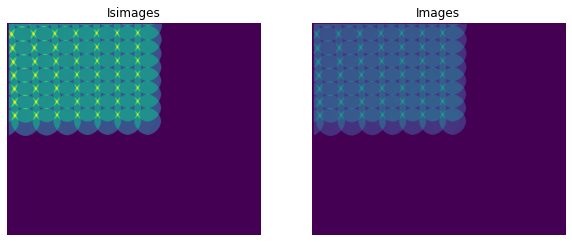

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,10))

im1 = ax[0].imshow(isimages)
ax[0].set_title('Isimages')
ax[0].axis('off')

im2 = ax[1].imshow(images)
ax[1].set_title('Images')
ax[1].axis('off')

(-0.5, 2447.5, 2047.5, -0.5)

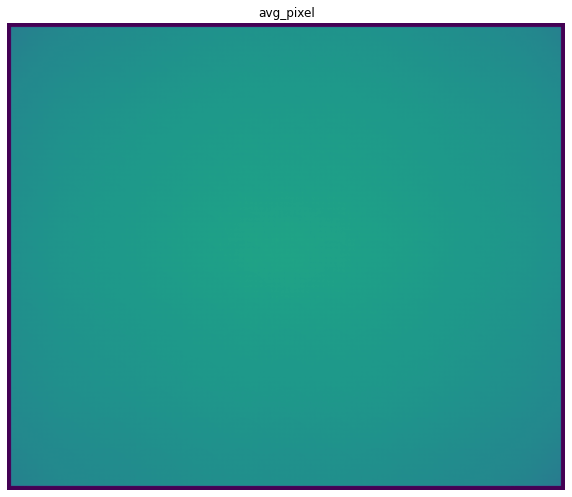

In [58]:
#averaging each pixel

#initializes a matrix with zeroes
avg_pixel = np.zeros([2048,2448])

#finds the average of each pixel
np.divide(images, isimages, out=avg_pixel, where=isimages !=0)

#rounds each value to 3 decimal places
avg_pixel = np.round(avg_pixel, decimals=3, out=avg_pixel)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

vis_avg_pixel = avg_pixel - avg_pixel.min()
vis_avg_pixel = vis_avg_pixel/vis_avg_pixel.max()
im1 = ax.imshow(vis_avg_pixel,vmin = 0, vmax = vis_avg_pixel.max())
ax.set_title('avg_pixel')
ax.axis('off')

In [54]:
print(avg_pixel.min(), avg_pixel.max())

0.0 3043.233


In [59]:
#save the matrix of averages
np.save('CalMatrix_2000cnts_1500ET_POL50_CAM101936', avg_pixel)


isimages = np.zeros([2048,2448]) 
images = np.zeros([2048,2448])
    
all_raw_images, all_meta_data = imager.capture_sequence(num_frames = 3, sleep_seconds1 = 0, 
        sleep_seconds2 =0, frames_per_round=5)
print('pictures')

mean = np.squeeze(np.array(all_raw_images)).mean(axis=0)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,10))

im1 = ax[0].imshow(mean)
ax[0].set_title('Isimages')
ax[0].axis('off')

im2 = ax[1].imshow(mean)
ax[1].set_title('Images')
ax[1].axis('off')

In [10]:


#declaring variables for borders
len_for_left = -24
len_for_right = 20
len_for_move_x = 3
num_for_row = int((abs(len_for_left)+abs(len_for_right)) / len_for_move_x)
len_for_move_y=2
len_for_up = 22
len_for_bottom = -20
num_for_col = int((abs(len_for_up)+abs(len_for_bottom))/len_for_move_y)



#connection to the gimbal

with Connection.open_serial_port("COM3") as connection: 
    device_list = connection.detect_devices()
    print("Found {} devices".format(len(device_list)))
   
    #get axes
    vertical = device_list[1].get_axis(1) #axis Y
    horizontal = device_list[0].get_axis(1) #axis X
    
    #go to origin
    #in theory this step is superfluous, but the function move_absolute doesn't alwyas work
    #sometimes moves relative
    
    horizontal.move_absolute(0, Units.ANGLE_DEGREES)
    vertical.move_absolute(0, Units.ANGLE_DEGREES)
    
   
    #starting point
#     horizontal.move_absolute(len_for_right, Units.ANGLE_DEGREES)
#     vertical.move_absolute(len_for_up, Units.ANGLE_DEGREES)

vertical.move_absolute(16, Units.ANGLE_DEGREES)
horizontal.move_absolute(-24, Units.ANGLE_DEGREES)
image = imager.get_images(show_images=False, save_images = False)
# image = image[0][0]
    
    
#     image = imager.get_images(show_images=True, save_images = False)
#     plt.show()
   

Found 2 devices


ConnectionClosedException: ConnectionClosedException: Connection has been closed

In [9]:
with Connection.open_serial_port("COM3") as connection: 
    device_list = connection.detect_devices()
    print("Found {} devices".format(len(device_list)))
   
    #get axes
    vertical = device_list[1].get_axis(1) #axis Y
    horizontal = device_list[0].get_axis(1) #axis X
    
  
 #declaring variables for borders
# len_for_left = 24 #negative 
# len_for_right = 16
# len_for_move_x = 3
# num_for_row = int((abs(len_for_left)+abs(len_for_right)) / len_for_move_x)
# len_for_move_y=2
# len_for_up = 16
# len_for_bottom = 16 #negative
# num_for_col = int((abs(len_for_up)+abs(len_for_bottom))/len_for_move_y)
  
    
vertical.move_absolute(16, Units.ANGLE_DEGREES)
horizontal.move_absolute(-24, Units.ANGLE_DEGREES)
image = imager.get_images(show_images=False, save_images = False)
# image = image[0][0]

Found 2 devices


ConnectionClosedException: ConnectionClosedException: Connection has been closed

(array([[2048.,    0.,    0., ...,    0.,    0.,    0.],
        [2048.,    0.,    0., ...,    0.,    0.,    0.],
        [2048.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [2048.,    0.,    0., ...,    0.,    0.,    0.],
        [2048.,    0.,    0., ...,    0.,    0.,    0.],
        [2048.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([1.0000e+00, 4.1030e+02, 8.1960e+02, 1.2289e+03, 1.6382e+03,
        2.0475e+03, 2.4568e+03, 2.8661e+03, 3.2754e+03, 3.6847e+03,
        4.0940e+03]),
 <a list of 2448 BarContainer objects>)

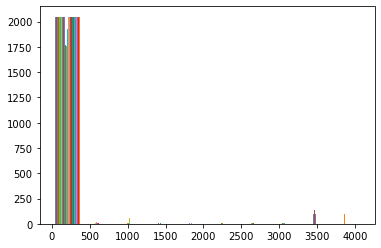

In [10]:
plt.hist(image)


In [6]:
plt.imshow(image)

NameError: name 'image' is not defined

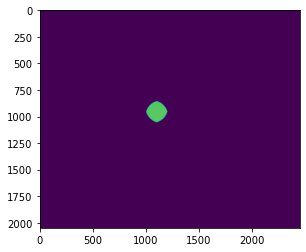

In [9]:
plt.imshow(imager.remove_frame(image, threshold=2000, kernel_size=80, close_first=True))

In [ ]:
angle = 0
np.save(mean, f"angle {angle}")

In [5]:

#declaring variables for borders
len_for_left = 24 #negative 
len_for_right = 16
len_for_move_x = 3
num_for_row = int((abs(len_for_left)+abs(len_for_right)) / len_for_move_x)
len_for_move_y=2
len_for_up = 16
len_for_bottom = 16 #negative
num_for_col = int((abs(len_for_up)+abs(len_for_bottom))/len_for_move_y)



image = imager.get_images(show_images=True, save_images = False)

0 - 2022-01-23 10:03:19.079132 - 101936 captured Mono12Packed image 


ValueError: x must have 2 or fewer dimensions

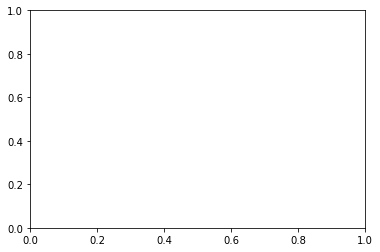

In [12]:
plt.hist(image)

C:\Users\Calibration\anaconda3\envs\imager\lib\site-packages\matplotlib\cbook\__init__.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

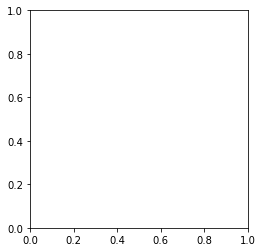

In [11]:
plt.imshow(image)

In [34]:
print(image.max())

3079


# REAL TIME STREAMING

In [39]:
num_images = 1
break_sets = 0 #in seconds
break_images = 0 # if == 0: 3 images are taken with no break (for repetition),
                         # then then there is a break_sets.
                         # if break_sets == break_images,
                         # there is no repetition.
            
raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)

0 - 2022-01-18 17:50:12.056944 - 101936 captured Mono12Packed image 


In [46]:
# REAL_TIME CAPTURE
font = cv2.FONT_HERSHEY_SIMPLEX
frame_cnt = 0

title = 'Real time stream'
cv2.namedWindow(title, cv2.WINDOW_NORMAL)

while(True):
    
#     start = time.time()
    raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
#     print("Executing an iteration took {} seconds".format(time.time()-start))
    
    raw_images = np.squeeze(np.array(raw_images))
    if num_images > 1:
        mean_image = np.mean(raw_images,axis=0)

    else:
        mean_image = raw_images
    
    
    
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # loop iteration/processing
    
                
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    frame_show = mean_image.copy()
    
    cv2.putText(frame_show,'Frame {}'
                .format(int(frame_cnt)),(10,50), font, 2,(255),2,cv2.LINE_AA)
    
    frame_cnt = frame_cnt + 1
    
    if PIXELFORMAT == 'Mono12Packed':
        frame_show = (2**8)*(frame_show/(2**12))
    
    frame_show = frame_show.astype('uint8')
    cv2.imshow(title, frame_show)
    
    key = cv2.waitKey(1) 
    # waitKey(1) will display a frame for 1 ms, after which display will be automatically closed.
    # Since the OS has a minimum time between switching threads, the function will not wait exactly 1 ms, it will 
    # wait at least 1 ms, depending on what else is running on your computer at that time.
    if key==ord('q'):
        break
        
    
 
cv2.destroyAllWindows()   

0 - 2022-01-18 17:52:05.388801 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:06.091487 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:06.719329 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:07.363602 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:08.031631 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:08.715519 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:09.432188 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:10.084193 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:10.736794 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:11.401817 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:12.037929 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:12.705722 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:13.371166 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:14.087533 - 101936 captured Mono12Packed image 
0 - 2022-01-18 17:52:14.772712 - 1

In [43]:
frame_show.max()

19

Found 2 devices
0 - 2022-01-19 10:26:07.636043 - 101936 captured Mono12Packed image 
1 - 2022-01-19 10:26:07.987270 - 101936 captured Mono12Packed image 
2 - 2022-01-19 10:26:08.367961 - 101936 captured Mono12Packed image 
3 - 2022-01-19 10:26:08.686767 - 101936 captured Mono12Packed image 
4 - 2022-01-19 10:26:09.083616 - 101936 captured Mono12Packed image 
5 - 2022-01-19 10:26:09.483060 - 101936 captured Mono12Packed image 
6 - 2022-01-19 10:26:09.850052 - 101936 captured Mono12Packed image 
7 - 2022-01-19 10:26:10.217165 - 101936 captured Mono12Packed image 
8 - 2022-01-19 10:26:10.540368 - 101936 captured Mono12Packed image 
9 - 2022-01-19 10:26:10.953486 - 101936 captured Mono12Packed image 
10 - 2022-01-19 10:26:11.305197 - 101936 captured Mono12Packed image 
11 - 2022-01-19 10:26:11.687068 - 101936 captured Mono12Packed image 
12 - 2022-01-19 10:26:12.070821 - 101936 captured Mono12Packed image 
13 - 2022-01-19 10:26:12.469380 - 101936 captured Mono12Packed image 
14 - 2022-01-1

13 - 2022-01-19 10:26:57.922049 - 101936 captured Mono12Packed image 
14 - 2022-01-19 10:26:58.274557 - 101936 captured Mono12Packed image 
0 - 2022-01-19 10:26:59.499776 - 101936 captured Mono12Packed image 
1 - 2022-01-19 10:26:59.940586 - 101936 captured Mono12Packed image 
2 - 2022-01-19 10:27:00.318345 - 101936 captured Mono12Packed image 
3 - 2022-01-19 10:27:00.710695 - 101936 captured Mono12Packed image 
4 - 2022-01-19 10:27:01.093564 - 101936 captured Mono12Packed image 
5 - 2022-01-19 10:27:01.477692 - 101936 captured Mono12Packed image 
6 - 2022-01-19 10:27:01.877146 - 101936 captured Mono12Packed image 
7 - 2022-01-19 10:27:02.230548 - 101936 captured Mono12Packed image 
8 - 2022-01-19 10:27:02.580547 - 101936 captured Mono12Packed image 
9 - 2022-01-19 10:27:02.960982 - 101936 captured Mono12Packed image 
10 - 2022-01-19 10:27:03.315663 - 101936 captured Mono12Packed image 
11 - 2022-01-19 10:27:03.697654 - 101936 captured Mono12Packed image 
12 - 2022-01-19 10:27:04.08136

12 - 2022-01-19 10:27:55.941163 - 101936 captured Mono12Packed image 
13 - 2022-01-19 10:27:56.294030 - 101936 captured Mono12Packed image 
14 - 2022-01-19 10:27:56.738362 - 101936 captured Mono12Packed image 
0 - 2022-01-19 10:27:58.038807 - 101936 captured Mono12Packed image 
1 - 2022-01-19 10:27:58.384607 - 101936 captured Mono12Packed image 
2 - 2022-01-19 10:27:58.757748 - 101936 captured Mono12Packed image 
3 - 2022-01-19 10:27:59.096951 - 101936 captured Mono12Packed image 
4 - 2022-01-19 10:27:59.495130 - 101936 captured Mono12Packed image 
5 - 2022-01-19 10:27:59.879696 - 101936 captured Mono12Packed image 
6 - 2022-01-19 10:28:00.294370 - 101936 captured Mono12Packed image 
7 - 2022-01-19 10:28:00.678758 - 101936 captured Mono12Packed image 
8 - 2022-01-19 10:28:01.095540 - 101936 captured Mono12Packed image 
9 - 2022-01-19 10:28:01.481027 - 101936 captured Mono12Packed image 
10 - 2022-01-19 10:28:01.849647 - 101936 captured Mono12Packed image 
11 - 2022-01-19 10:28:02.21676

11 - 2022-01-19 10:28:47.884716 - 101936 captured Mono12Packed image 
12 - 2022-01-19 10:28:48.284447 - 101936 captured Mono12Packed image 
13 - 2022-01-19 10:28:48.669413 - 101936 captured Mono12Packed image 
14 - 2022-01-19 10:28:49.021846 - 101936 captured Mono12Packed image 
0 - 2022-01-19 10:28:50.584103 - 101936 captured Mono12Packed image 
1 - 2022-01-19 10:28:50.929765 - 101936 captured Mono12Packed image 
2 - 2022-01-19 10:28:51.270905 - 101936 captured Mono12Packed image 
3 - 2022-01-19 10:28:51.639549 - 101936 captured Mono12Packed image 
4 - 2022-01-19 10:28:51.991844 - 101936 captured Mono12Packed image 
5 - 2022-01-19 10:28:52.373925 - 101936 captured Mono12Packed image 
6 - 2022-01-19 10:28:52.726842 - 101936 captured Mono12Packed image 
7 - 2022-01-19 10:28:53.108655 - 101936 captured Mono12Packed image 
8 - 2022-01-19 10:28:53.522507 - 101936 captured Mono12Packed image 
9 - 2022-01-19 10:28:53.941212 - 101936 captured Mono12Packed image 
10 - 2022-01-19 10:28:54.32715

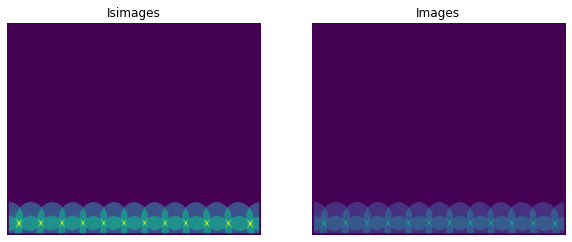

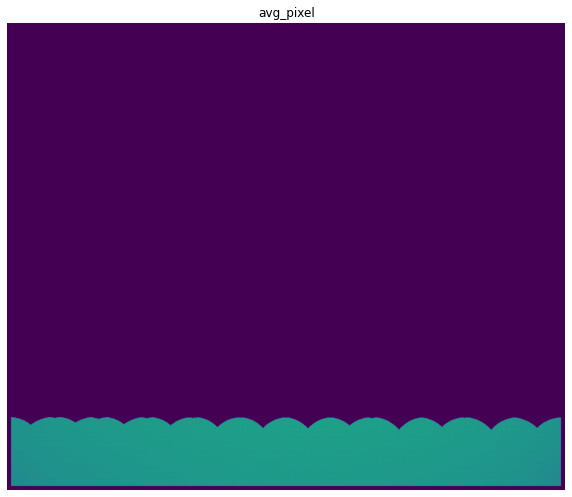

In [30]:

#declaring variables for borders
len_for_left = 24 #negative 
len_for_right = 16
len_for_move_x = 3
num_for_row = int((abs(len_for_left)+abs(len_for_right)) / len_for_move_x)
len_for_move_y=2
len_for_up = 16
len_for_bottom = 16 #negative
num_for_col = int((abs(len_for_up)+abs(len_for_bottom))/len_for_move_y)

time.sleep(10)

#connection to the gimbal

with Connection.open_serial_port("COM3") as connection: 
    device_list = connection.detect_devices()
    print("Found {} devices".format(len(device_list)))
   
    #get axes
    vertical = device_list[1].get_axis(1) #axis Y
    horizontal = device_list[0].get_axis(1) #axis X
    
    #go to origin
    #in theory this step is superfluous, but the function move_absolute doesn't alwyas work
    #sometimes moves relative
    
    horizontal.move_absolute(0, Units.ANGLE_DEGREES)
    vertical.move_absolute(0, Units.ANGLE_DEGREES)
    
   
       
    #starting point
    horizontal.move_absolute(len_for_right, Units.ANGLE_DEGREES)
    vertical.move_absolute(len_for_up, Units.ANGLE_DEGREES)
   
    
    #initialization
    isimages = np.zeros([2048,2448]) 
    images = np.zeros([2048,2448])  
    
   
     # scans the frame and takes pictures
    for cstep in range(num_for_col):
          
        for rstep in range(num_for_row):
          
            
            #checkpt is a tuple with 2 matrices
            #images: contains the sum of the light values from all the images
            #isimages: contains the number of times a certain pixel surviced the threshold
           
            (isimages, images), mean = imager.capture_sequence_and_get_cover(num_frames = 15, sleep_seconds1 = 0, 
                    sleep_seconds2 =0, frames_per_round=5,close_first= True, chckpt=(isimages, images))
           
            
            horizontal.move_relative(-1*len_for_move_x, Units.ANGLE_DEGREES)
            
            
         
        horizontal.move_absolute(len_for_right, Units.ANGLE_DEGREES)
        vertical.move_relative(-1*len_for_move_y, Units.ANGLE_DEGREES)
        
        if cstep == 1:
            break
        
        
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,10))

    im1 = ax[0].imshow(isimages)
    ax[0].set_title('Isimages')
    ax[0].axis('off')

    im2 = ax[1].imshow(images)
    ax[1].set_title('Images')
    ax[1].axis('off')    


    #averaging each pixel

    #initializes a matrix with zeroes
    avg_pixel = np.zeros([2048,2448])

    #finds the average of each pixel
    np.divide(images, isimages, out=avg_pixel, where=isimages !=0)

    #rounds each value to 3 decimal places
    avg_pixel = np.round(avg_pixel, decimals=3, out=avg_pixel)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

    vis_avg_pixel = avg_pixel - avg_pixel.min()
    vis_avg_pixel = vis_avg_pixel/vis_avg_pixel.max()
    im1 = ax.imshow(vis_avg_pixel,vmin = 0, vmax = vis_avg_pixel.max())
    ax.set_title('avg_pixel')
    ax.axis('off')

    print(avg_pixel.min(), avg_pixel.max())